In [1]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from dateutil.parser import parse
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import time
from datetime import datetime, timezone
from dateutil import parser
import oandapyV20.endpoints.instruments as instruments
import configparser
import json
from oandapyV20 import API
import oandapyV20.endpoints.positions as positions
import oandapyV20.endpoints.trades as trades
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.accounts as accounts
from oandapyV20.contrib.factories import InstrumentsCandlesFactory
from oandapyV20.contrib.requests import MarketOrderRequest, TrailingStopLossDetails
from oandapyV20.exceptions import V20Error, StreamTerminated
import sqlite3
from collections import OrderedDict, ChainMap

In [2]:
#https://oanda-api-v20.readthedocs.io/en/latest/index.html
config = configparser.ConfigParser()
config.read('oanda_new.cfg')

client = API(access_token=config['oanda']['access_token'])

In [3]:
def get_data(_from, _to, granularity, instrument, save_csv=False):
    """
        Collect historical data for training
        _from="2018-01-01 00:00"    date and time to start collecting candles
        _to=""                      date and time to end the collection of candles, if "", then end will be now.
        save_csv if True will save csv file in current folder
    """
    if _to == "":
        _to = datetime.strptime(datetime.now().isoformat()[0:19] + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    else:
        _to = datetime.strptime(parser.parse(_to).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    params = {
    "granularity": granularity,
    "from": datetime.strptime(parser.parse(_from).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ'),
    "to": _to
    }
    
    df = pd.DataFrame(columns=["Date", 'Open', 'High', 'Low', 'Close', "Volume"])
    for r in InstrumentsCandlesFactory(instrument=instrument, params=params):
        rv = client.request(r)

        results = [{"Date":candle['time'][0:19], "Open":float(candle['mid']['o']),
                    "High":float(candle['mid']['h']), "Low":float(candle['mid']['l']),
                   "Close":float(candle['mid']['c']), "Volume": float(candle['volume'])
                   } for candle in r.response.get('candles')]
        df = df.append(pd.DataFrame(results), ignore_index=True)
    
    df.set_index("Date", inplace=True)
    if save_csv:
        df.to_csv(instrument + "_" + granularity + ".csv")
    return df

In [4]:
start = "2021-07-16 00:00"    #date and time to start collecting candles
end = ""    #date and time to end the collection of candles, if "", then end will be now.
granularity = "M1"
instrument = "IN50_USD"


In [5]:
df = get_data(_from=start, _to=end, granularity=granularity, instrument=instrument, save_csv=False)
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist() 
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-07-19T18:57:00,15647.8,15651.5,15643.9,15644.5,95.0
2021-07-19T18:58:00,15644.3,15644.5,15635.8,15636.0,129.0
2021-07-19T18:59:00,15636.3,15638.7,15633.9,15633.9,86.0
2021-07-19T19:00:00,15634.1,15637.5,15633.3,15635.1,99.0
2021-07-19T19:01:00,15634.9,15635.5,15633.8,15633.8,12.0


In [6]:
import talib as ta
from talib import MA_Type

def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    df_new['Open'] = df['Open']
    df_new['High'] = df['High']     
    df_new['Low'] = df['Low'] 
    df_new['Close'] = df['Close']  
    df_new['Trend'] = ta.HT_TRENDLINE(df_new['Close'])
    df_new['EMA'] = ta.EMA(df_new['Close'], timeperiod = 20)
    df_new['EMA2'] = ta.EMA(df_new['EMA'], timeperiod = 20)
    df_new['EMA3'] = ta.EMA(df_new['EMA2'], timeperiod = 20)
    
    
        
  
    df_new = df_new.dropna(axis=0)
    return df_new

In [7]:
df = generate_features(df)
df.tail()

,Open,High,Low,Close,Trend,EMA,EMA2,EMA3
Date,,,,,,,,
2021-07-19T18:57:00,15647.8,15651.5,15643.9,15644.5,15651.339526,15645.132724,15648.965212,15652.934735
2021-07-19T18:58:00,15644.3,15644.5,15635.8,15636.0,15650.337561,15644.262941,15648.517377,15652.514035
2021-07-19T18:59:00,15636.3,15638.7,15633.9,15633.9,15649.224596,15643.275994,15648.018197,15652.085860
2021-07-19T19:00:00,15634.1,15637.5,15633.3,15635.1,15648.234060,15642.497328,15647.492400,15651.648387
2021-07-19T19:01:00,15634.9,15635.5,15633.8,15633.8,15647.511460,15641.669011,15646.937792,15651.199759


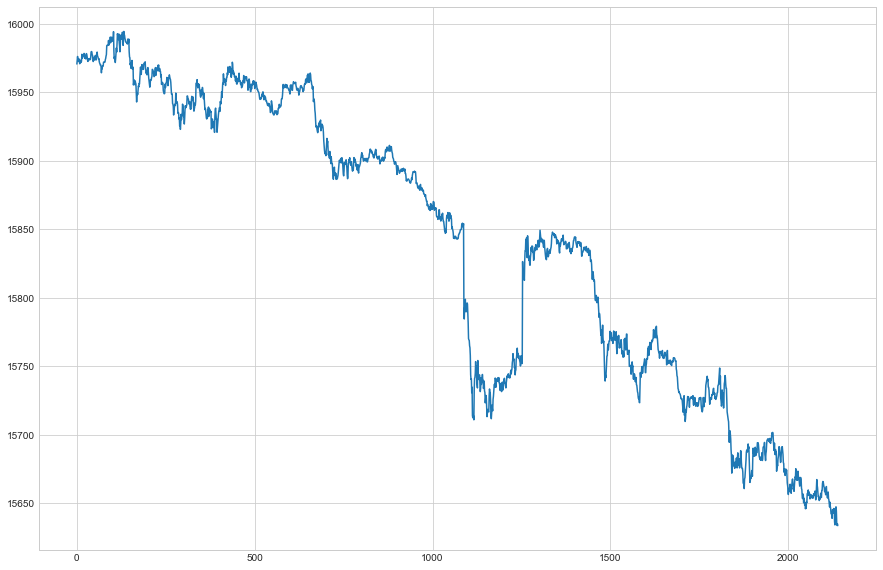

In [8]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])


ax.plot(
    x_range_original,
    df['Close'][0:],
    color = current_palette[1],
)

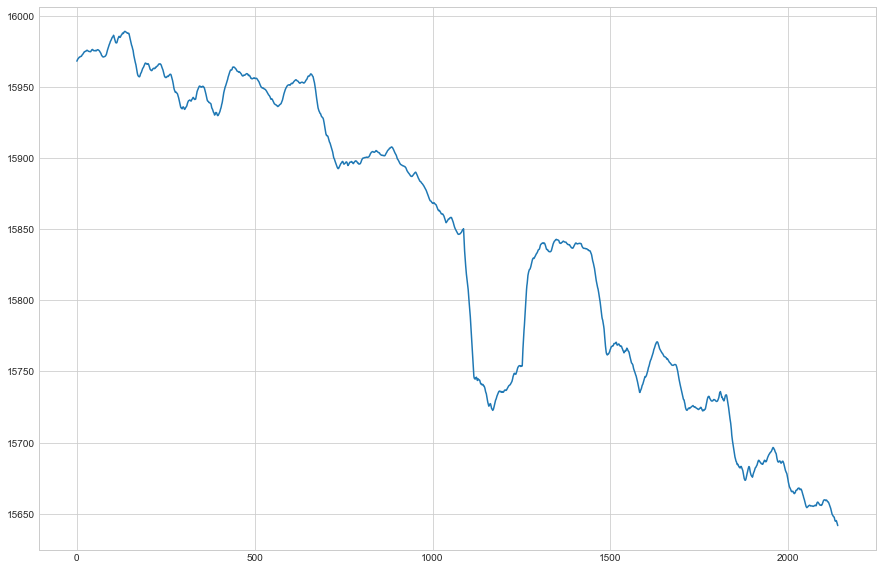

In [9]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])


ax.plot(
    x_range_original,
    df['EMA'][0:],
    color = current_palette[1],
)

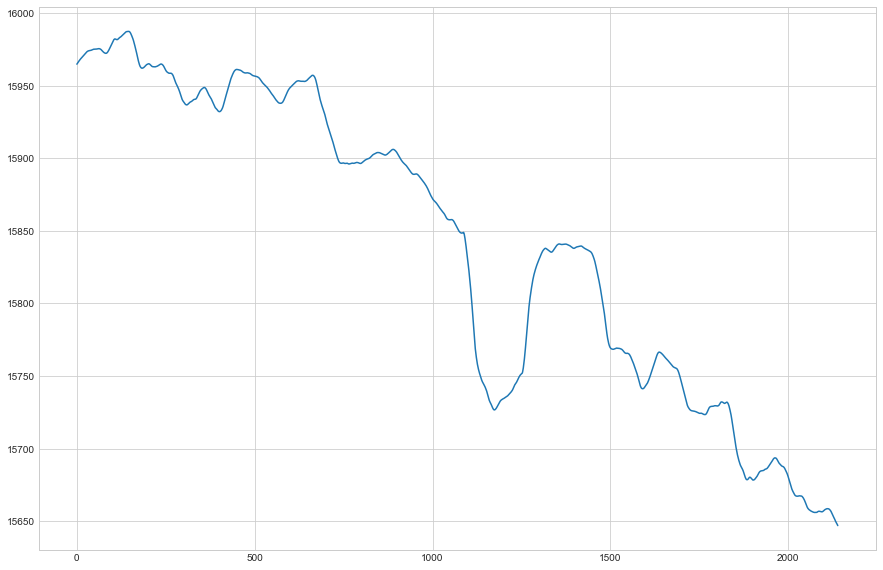

In [10]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])


ax.plot(
    x_range_original,
    df['EMA2'][0:],
    color = current_palette[1],
)

In [11]:
np.diff(df['EMA2'])

array([ 0.34405412,  0.380737  ,  0.37647299, ..., -0.4991793 ,
       -0.52579709, -0.5546085 ])

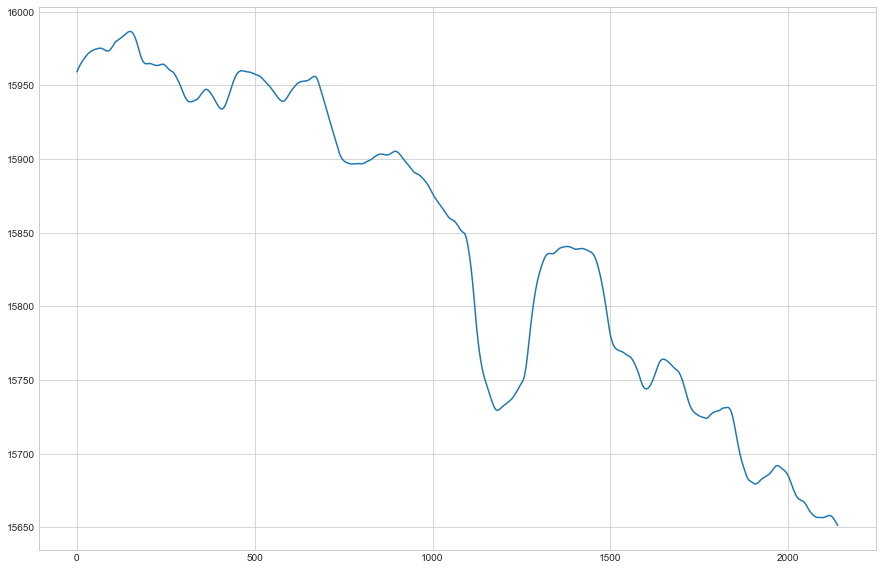

In [12]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])


ax.plot(
    x_range_original,
    df['EMA3'][0:],
    color = current_palette[1],
)

In [13]:
np.diff(df['EMA3'])

array([ 0.58101329,  0.56193936,  0.54427589, ..., -0.42817497,
       -0.43747232, -0.44862815])

In [14]:
df.diff(periods=1)


,Open,High,Low,Close,Trend,EMA,EMA2,EMA3
Date,,,,,,,,
2021-07-16T02:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-16T02:04:00,2.3,4.0,2.5,2.5,0.122697,0.490195,0.344054,0.581013
2021-07-16T02:05:00,2.9,1.3,2.3,3.0,0.193671,0.729224,0.380737,0.561939
2021-07-16T02:06:00,2.6,-0.2,-1.0,-3.4,0.122190,0.335965,0.376473,0.544276
2021-07-16T02:07:00,-3.0,-1.1,1.0,0.0,0.104872,0.303968,0.369568,0.527637
...,...,...,...,...,...,...,...,...
2021-07-19T18:57:00,1.1,4.0,-0.1,-3.0,-0.578807,-0.066603,-0.403420,-0.417845
2021-07-19T18:58:00,-3.5,-7.0,-8.1,-8.5,-1.001965,-0.869783,-0.447835,-0.420701
2021-07-19T18:59:00,-8.0,-5.8,-1.9,-2.1,-1.112965,-0.986947,-0.499179,-0.428175


In [15]:
def get_candles(count, granularity, price='B'):
    params={"count": count, "granularity": granularity, 'price': price}
    r = instruments.InstrumentsCandles(instrument=instrument,params=params)
    data = client.request(r)
    
    if price == 'B':
        p = 'bid'
    elif price == 'A':
        p = 'ask'
    results= [{"Date":x['time'],"Open":float(x[p]['o']),"High":float(x[p]['h']),
               "Low":float(x[p]['l']), "Close":float(x[p]['c']), "Volume": float(x['volume'])
              } for x in data['candles'] ] #if x["complete"]
    df = pd.DataFrame(results).set_index('Date')
    df.index = pd.DatetimeIndex(df.index)
    
    return df[["Open", "High", "Low", "Close", "Volume"]]
            


In [16]:
def create_order(units, instrument, sld):
    #sld = trailing stop loss distance
    
    dfOrder = pd.DataFrame()
    order = orders.OrderCreate(accountID=config['oanda']['account_id'], 
                               data=MarketOrderRequest(instrument=instrument, units=units, 
                                                       trailingStopLossOnFill=TrailingStopLossDetails(distance=sld).data).data)
    response = client.request(order)
    
    print(response["orderFillTransaction"]['time'], "--",
          "Instrument = ", response['orderFillTransaction']['instrument'], "--",
          "Price = ", float(response['orderFillTransaction']['price']), "--",
          "PL = ", float(response['orderFillTransaction']['pl']))

{'positions': [], 'lastTransactionID': '1797'}
                              Open     High      Low    Close         Trend  \
Date                                                                          
2021-07-19T18:58:00        15644.3  15644.5  15635.8  15636.0  15650.337561   
2021-07-19T18:59:00        15636.3  15638.7  15633.9  15633.9  15649.224596   
2021-07-19T19:00:00        15634.1  15637.5  15633.3  15635.1  15648.234060   
2021-07-19T19:01:00        15634.9  15635.5  15633.8  15633.8  15647.511460   
2021-07-19 19:01:00+00:00  15633.4  15634.0  15632.3  15632.3           NaN   

                                    EMA          EMA2          EMA3  Volume  
Date                                                                         
2021-07-19T18:58:00        15644.262941  15648.517377  15652.514035     NaN  
2021-07-19T18:59:00        15643.275994  15648.018197  15652.085860     NaN  
2021-07-19T19:00:00        15642.497328  15647.492400  15651.648387     NaN  
2021-07-1

KeyboardInterrupt: 

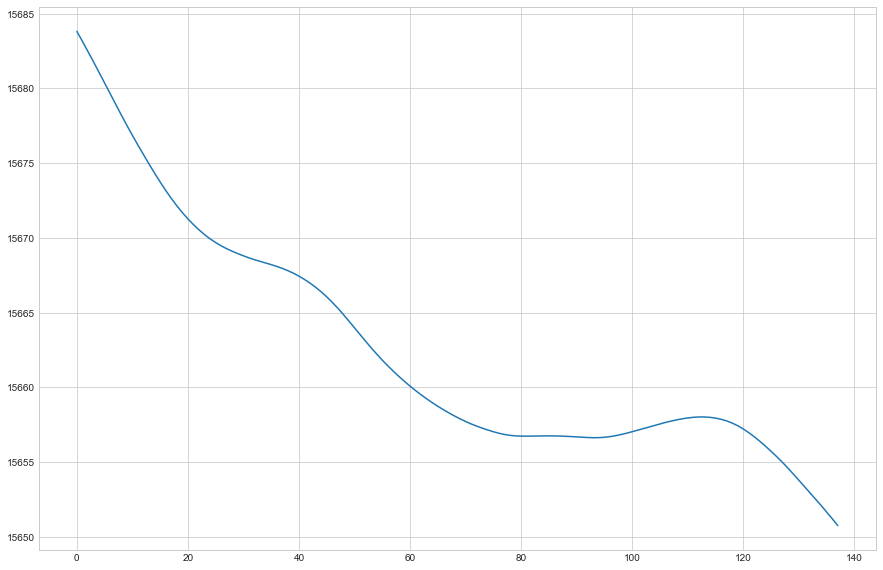

In [17]:
# Below is the while Loop that is used to append the the close data from the pricing stream over time. 
# Like this with every iteration the Renko chart can be built again and new Renko bars get shown. 

from time import sleep



df3 =  df.iloc[-200:]

units = 1
sld = 27

while True:
    

    
    df2 = get_candles(count=1, granularity='M1')
    df2.index.name = "Date"
    
    r = positions.OpenPositions(accountID='101-004-11521897-001')
    client.request(r)
    print(r.response) 
    
    t = df.index[-1]
    t_old = None
    
    if t_old is None or t != t_old:
        t_old = df.index[-1]
        

        # Trade
        #get position from broker
        global position
        r = trades.OpenTrades(accountID=config['oanda']['account_id'])
        t = dict(ChainMap(*client.request(r)["trades"]))
        try:
            position = float(t["currentUnits"])
        except:
            position = 0

    sleep(60)
    

    df3 = df3.append(df2)
    

    print(df3.tail())

    # hier kommt noch das df mit den aktuellen Werten für EMA1 - 3 hinein. 


    df = generate_features(df3)
    df.tail()


    # Here I have built in the trading logic to show a working trading strategy 

    if np.diff(df['EMA3'])[-1] < 0 and position == 0:
        create_order(units=-units, instrument="IN50_USD", sld=sld)
        print('SELL')

    elif np.diff(df['EMA3'])[-1] > 0 and position == -units:
        create_order(units= units, instrument="IN50_USD", sld=sld)
        print('Close Short Position')

    if np.diff(df['EMA3'])[-1] > 0 and position == 0:
        create_order(units=units, instrument="IN50_USD", sld=sld)
        print('Buy')

    elif np.diff(df['EMA3'])[-1] < 0 and position == units:
        create_order(units= -units, instrument='IN50_USD', sld=sld)
        print('Close Long Position')
        
        
    current_palette = sns.color_palette('Paired', 12)
    fig = plt.figure(figsize = (15, 10))
    ax = plt.subplot(111)
    x_range_original = np.arange(df.shape[0])


    ax.plot(
        x_range_original,
        df['EMA3'][0:],
        color = current_palette[1],
    )